In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
import scipy.io
import scipy.interpolate
from scipy import signal
from matplotlib import patches
from IPython.display import HTML


plt.rcParams['figure.figsize'] = [10, 5]

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from sklearn.decomposition import PCA
import mglearn
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.datasets import make_moons
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

#### Creating Epochs

In [2]:
class EEG_File:
    """
    A class to import and store relevant eeg files

    Attributes
    ----------
    experiment : str
        experiment folder name within the data folder
    mat : list(int)
        a list of integers representing impact times
    raw : mne.io.Raw
        raw experiment data in FIF format
    """

    def __init__(self, experiment):
        self.experiment = experiment
        self.mat = scipy.io.loadmat("data/"+experiment+"/impact locations.mat")
        self.raw = mne.io.read_raw_eeglab("data/"+experiment+"/fixica.set")


class Epochs:
    """
    A class to represent epochs and underlying data

    Attributes
    ----------
    eeg_file : EEG_File
        eeg file data
    data : mne.Epochs
        the generated epoch data

    Methods
    -------
    generate_epochs(duration, start_second):
        Calculates epochs based on a duration and start second
    """

    def __init__(self, experiment, duration=2, start_second=None):
        self.eeg_file = EEG_File(experiment)
        self.data = self.generate_epochs(duration, start_second)

    def generate_epochs(self, duration, start_second):
        if start_second:
            start_time = start_second*2049
            stim_mock = [[start_time]]
            tmin = 0
            tmax = duration
        else:
            stim_mock = self.eeg_file.mat["elecmax1"]
            tmin = -0.3
            tmax = tmin + duration
            print(tmax)

        events = [[ts, 0, i+1] for i, ts in enumerate(stim_mock[0])]

        epochs = mne.Epochs(
            self.eeg_file.raw,
            events,
            tmin=tmin,
            tmax=tmax,
            preload=True,
            baseline=(0, 0)
        )

        return epochs


## Introduction

Electroencephalograms (EEG) is an electrophysiological measurement method used to examine the electrical activity of the brain and represent it as location-based channels of waves and frequencies. Essentially, the EEG data from our dataset is recorded from 19 electrodes nodes for 1.5 hours. Therefore, the EEG data is in high dimensionality and could be represented as a multivariate time series data. If we present the data in a tabular format, the number of rows would be the time stamps and the number of columns would be the different electrodes. As we have 1.5 hrs experiment data and each seconds is recorded at 2048 Hz, which means we have 2048 EEG data readings per second, our dataset is large with at least 1 million rows.

## Objectives

EEG data is widely use in diagnosing brain disorders such as epilepsy and brain damage from head injuries, however, with the complexity of data and its dynamic changes over time, it is hard to identify any significant patterns by simply reading the data or visualizing it. The main objective of this strech goal is to find similar patterns from the combination of EEG signals of all 19 electrodes for a given time section from the dataset. In plain English, it is to cluster the brain states for different time periods in the data.

#### Reading EEGLAB data

In [3]:
raw = mne.io.read_raw_eeglab('../../data/fixica.set')
# raw = mne.io.read_epochs_eeglab('../data/online_test.set')

Reading C:\Users\mgaro\UBC-MDS\Capstone\simpl_eeg_capstone\data\fixica.fdt


<ipython-input-3-bd7e32e41eaa>:1: RuntimeWarning: Data file name in EEG.data (109 whole fixed ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../../data/fixica.set')


In [4]:
raw = raw.set_eeg_reference(projection=True)

Adding average EEG reference projection.
1 projection items deactivated


In [5]:
type(raw)

mne.io.eeglab.eeglab.RawEEGLAB

In [6]:
raw

<RawEEGLAB | fixica.fdt, 19 x 11175225 (5456.7 s), ~32 kB, data not loaded>

In [ ]:
# Calculate starting/ending frames
start_hour = 0
start_minute = 17
start_second = 6
start_ms = 86

end_hour = 0
end_minute = 17
end_second = 7
end_ms = 50


sampling_freq_hz = raw.info.get('sfreq') 

start_frame = round((sampling_freq_hz/1000) * start_ms) \
    + (start_second * sampling_freq_hz) \
    + (start_minute * (sampling_freq_hz * 60)) \
    + (start_hour * (sampling_freq_hz * 3600))
# Calculate starting/ending frames
start_hour = 0
start_minute = 17
start_second = 6
start_ms = 86

sampling_freq_hz = raw.info.get('sfreq') 

start_frame = round((sampling_freq_hz/1000) * start_ms) \
    + (start_second * sampling_freq_hz) \
    + (start_minute * (sampling_freq_hz * 60)) \
    + (start_hour * (sampling_freq_hz * 3600))


In [7]:
raw.times

array([0.00000000e+00, 4.88281250e-04, 9.76562500e-04, ...,
       5.45665137e+03, 5.45665186e+03, 5.45665234e+03])

#### Converting raw data to data frame

In [8]:
raw_df = raw.to_data_frame()

In [22]:
#raw_df.set_index('time')

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
time,,,,,,,,,,,,,,,,,,,
0,-1.309180,-17.504066,-0.934941,12.458370,3.110043,0.399445,-0.824427,8.192215,2.764535,-1.003163,4.253562,13.615928,3.193182,9.777016,2.023224,8.134605,15.983869,-3.551786,7.306483
0,-1.366664,-17.707190,-0.935696,12.504413,3.016100,0.431123,-0.944412,8.104908,2.741335,-1.053120,4.191818,13.737228,3.309192,9.774727,2.021176,8.193565,15.941096,-3.612502,7.278894
1,15.275132,-1.613967,25.944092,16.369394,19.123390,20.245935,27.153799,32.618656,4.682581,14.432489,20.894924,-2.061573,-16.849432,13.966457,14.188269,0.948726,35.616409,6.693176,16.724426
1,15.259221,-1.763359,25.982115,16.439892,19.149214,20.305655,27.087055,32.651844,4.582679,14.375604,20.861244,-2.067911,-16.759865,13.921695,14.239827,0.961342,35.574158,6.814420,16.962944
2,24.320646,21.294743,29.273348,36.190701,30.900623,21.696165,32.211964,43.833370,4.397994,24.987123,32.643608,-18.852341,-7.435656,24.248709,12.634859,0.314506,32.368336,19.638361,16.652056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456650,-0.211792,10.697310,-14.531826,12.793026,-9.036341,-16.845898,-21.756701,-9.844389,-18.925793,-11.286021,-10.296985,-14.877690,-4.805411,-10.968634,-12.127897,-7.813345,-9.517270,-7.663065,-2.985892
5456651,0.161600,10.186489,-13.580552,6.596169,-9.434369,-16.212305,-18.521297,-8.370523,-18.869396,-10.713539,-7.271566,-11.472207,-4.956153,-8.000952,-8.690601,-5.604794,-5.389194,-8.054649,5.840395
5456651,-3.728542,3.934337,-14.654056,-4.194075,-7.884426,-12.769772,-15.568685,-4.896610,-16.460442,-9.753442,-5.234596,-9.115169,-3.668637,-10.375922,-14.358104,-7.003763,-5.554564,-2.668821,-2.436323


In [9]:
raw_df.shape

(11175225, 20)

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175225 entries, 0 to 11175224
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   Fp1     float64
 2   Fp2     float64
 3   F7      float64
 4   T3      float64
 5   T5      float64
 6   F3      float64
 7   C3      float64
 8   P3      float64
 9   Fz      float64
 10  Cz      float64
 11  Pz      float64
 12  F4      float64
 13  C4      float64
 14  P4      float64
 15  F8      float64
 16  T4      float64
 17  T6      float64
 18  O1      float64
 19  O2      float64
dtypes: float64(19), int64(1)
memory usage: 1.7 GB


In [11]:
# Create new data frame for 50,001 timestamps for analysis
raw_60k = raw_df.loc[10000:60000, :]
raw_60k.tail()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
59996,29295,-1.665951,-8.463483,2.767287,4.149964,7.607449,3.883847,6.312657,4.561931,9.797362,2.729219,3.302557,8.168802,10.671643,8.534129,5.199719,6.985191,-3.325593,6.166866,1.902911
59997,29295,-2.840300,-12.046831,-1.815832,-0.131912,6.544355,-2.093999,3.319209,3.506616,6.525228,-4.571234,0.097840,3.730470,9.143910,6.349403,4.555594,6.311711,-1.255698,3.042827,1.702189
59998,29296,-2.467201,-5.800088,-0.936508,-6.575222,3.666990,-3.637801,2.692691,-0.617673,1.693227,-6.712663,-2.054039,-2.537172,4.406703,1.556428,4.447454,2.726656,-3.282669,1.679513,0.527909
59999,29296,-1.443697,-3.867588,-2.419806,-21.868748,0.798535,-4.727095,5.878745,0.138380,-0.706549,-7.631720,-2.800089,-2.781269,4.124086,-0.415853,4.646212,2.153330,-3.031017,-1.314206,3.492633
60000,29297,-1.103712,-2.369061,-4.281667,-35.676662,-1.996497,-4.489472,8.061417,1.711861,-1.010798,-6.127204,-2.220078,-3.724544,2.076321,0.333713,0.554102,0.761706,-3.603914,-1.954512,-0.808997


In [ ]:
#Export as .csv
raw_60k.to_csv('raw_60k.csv')

In [4]:
df = pd.read_csv("raw_60k.csv")

In [5]:
df.tail()

,Unnamed: 0,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,...,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
49996,59996,29295,-1.665951,-8.463483,2.767287,4.149964,7.607449,3.883847,6.312657,4.561931,...,2.729219,3.302557,8.168802,10.671643,8.534129,5.199719,6.985191,-3.325593,6.166866,1.902911
49997,59997,29295,-2.840300,-12.046831,-1.815832,-0.131912,6.544355,-2.093999,3.319209,3.506616,...,-4.571234,0.097840,3.730470,9.143910,6.349403,4.555594,6.311711,-1.255698,3.042827,1.702189
49998,59998,29296,-2.467201,-5.800088,-0.936508,-6.575222,3.666990,-3.637801,2.692691,-0.617673,...,-6.712663,-2.054039,-2.537172,4.406703,1.556428,4.447454,2.726656,-3.282669,1.679513,0.527909
49999,59999,29296,-1.443697,-3.867588,-2.419806,-21.868748,0.798535,-4.727095,5.878745,0.138380,...,-7.631720,-2.800089,-2.781269,4.124086,-0.415853,4.646212,2.153330,-3.031017,-1.314206,3.492633
50000,60000,29297,-1.103712,-2.369061,-4.281667,-35.676662,-1.996497,-4.489472,8.061417,1.711861,...,-6.127204,-2.220078,-3.724544,2.076321,0.333713,0.554102,0.761706,-3.603914,-1.954512,-0.808997


In [6]:
# DROP UNNAMED: 0 and TIME
df = df.drop(columns = ['Unnamed: 0', 'time'])

In [ ]:
df_range = df.rolling(window=50).mean()
df_range.tail(10)

In [7]:
# Convert to array
X = df_range.to_numpy()

In [8]:
X

array([[  2.740062  ,  -8.0630579 ,  13.38563538, ...,   3.14364433,
        -10.28514671,   3.92269301],
       [  1.79040277,  -6.18236303,  10.88659286, ...,   1.20849025,
         -9.28272724,   0.91416323],
       [  0.45542377,  -5.38073492,   5.54939222, ...,   1.27860522,
        -11.69928455,  -3.57692599],
       ...,
       [ -2.46720052,  -5.80008841,  -0.93650788, ...,  -3.28266907,
          1.6795131 ,   0.52790874],
       [ -1.44369686,  -3.8675878 ,  -2.41980624, ...,  -3.03101707,
         -1.31420612,   3.49263287],
       [ -1.10371172,  -2.36906099,  -4.28166676, ...,  -3.6039145 ,
         -1.95451248,  -0.80899704]])

## K-Means Clustering

 

**Clustering** is the task of partitioning the dataset into groups called clusters.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

#### K-Means using `sklearn`

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points (Represent each cluster by its cluster center and assign a cluster membership to each data point)

In [14]:
# fit the data
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [15]:
# Predict the clusters
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
kmeans.cluster_centers_

array([[ -1.10674849,  -0.15991501,  -2.66777629,  -4.1800266 ,
         -3.46435721,  -3.06056483,  -3.63682161,  -3.88359551,
         -2.55951821,  -3.54096826,  -3.7065025 ,  -2.81049646,
         -3.21764246,  -3.03610433,  -1.93312652,  -2.00922382,
         -2.2991468 ,  -2.45938311,  -2.48250317],
       [  3.98043394,  -2.59014663,  15.34824952,  22.51273646,
         18.94586121,  17.58411135,  18.93677024,  18.82462148,
         15.66059307,  18.92207411,  18.78694343,  17.96611956,
         19.29145021,  18.15359218,  12.62301282,  13.15768908,
         15.03767307,  15.10827704,  15.13853873],
       [ -4.57712323,  -0.66299137, -11.03473084, -17.23368813,
        -14.77284802, -13.11502428, -15.5603929 , -15.89603531,
        -12.49601882, -15.79497431, -15.51363677, -13.16546097,
        -16.02136865, -14.53563202,  -9.37140426, -10.08606643,
        -11.22853031, -10.85092433, -11.85706996],
       [  1.10683153,  -0.13282523,   3.36072203,   4.260555  ,
          5.854

In [11]:
# Create new data frame with the 
raw_predict = df_range.copy()
raw_predict["Cluster"] = kmeans.predict(df_range)
raw_predict.head(15)

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
0,2.740062,-8.063058,13.385635,-24.336906,-11.789210,10.230266,4.006072,-12.459600,3.065067,-0.853008,-13.468228,3.642864,2.229358,-0.679119,16.472950,4.808193,3.143644,-10.285147,3.922693,3
1,1.790403,-6.182363,10.886593,-19.182930,-9.793828,8.341944,3.397304,-13.212625,6.278689,-0.848276,-12.231605,3.119982,3.451186,-1.857235,15.294305,4.149238,1.208490,-9.282727,0.914163,3
2,0.455424,-5.380735,5.549392,-4.844332,-11.341512,2.393203,-5.890293,-16.344589,3.155915,-4.142987,-13.306343,0.035439,-0.512688,-2.799185,9.932633,2.123544,1.278605,-11.699285,-3.576926,3
3,1.536222,0.369180,1.755456,2.366043,-13.096667,-1.539799,-11.697590,-18.330090,-0.657635,-4.556225,-16.217484,-3.778996,-2.228258,-5.390731,5.894307,-0.293921,0.273714,-13.598961,-5.787669,3
4,0.647300,0.365889,1.150007,-2.246791,-13.873303,-5.271249,-11.024563,-20.210754,-3.730378,-9.289450,-16.612837,-5.171111,-4.803694,-6.881007,8.022381,-0.408774,0.469546,-16.808533,-3.426665,3
5,1.489856,-2.994609,3.988149,-14.861001,-11.498686,-2.460310,-3.845020,-16.585489,-0.271562,-8.223895,-16.344389,-2.880741,-2.202476,-2.198266,14.244060,3.498279,8.173867,-14.394930,4.452629,3
6,0.486653,-2.467967,9.473022,-23.824631,-11.018328,1.176446,1.863291,-17.627094,0.053920,-7.039565,-14.238010,-1.101542,-1.219307,-0.869411,18.275398,4.993651,7.279816,-12.413582,5.747094,3
7,3.245857,-5.208934,12.096435,-16.906988,-7.383633,4.985415,5.395522,-12.421244,4.838556,-4.014222,-11.776717,0.824130,4.194140,1.459440,20.884060,7.058623,8.679201,-12.089344,5.860099,3
8,6.945580,-3.772228,15.783804,-10.101851,-3.307833,11.456183,11.143613,-4.234347,11.060272,4.411132,-5.736935,3.133379,3.593632,5.676408,18.992983,6.558821,8.031758,-9.189837,1.806345,1
9,8.893146,2.357722,16.514044,-0.449004,-0.568541,12.656273,12.744141,-1.560452,11.123634,8.299058,-2.205358,4.954393,6.835973,2.771649,18.976366,6.032388,10.388539,-9.274957,3.443763,1


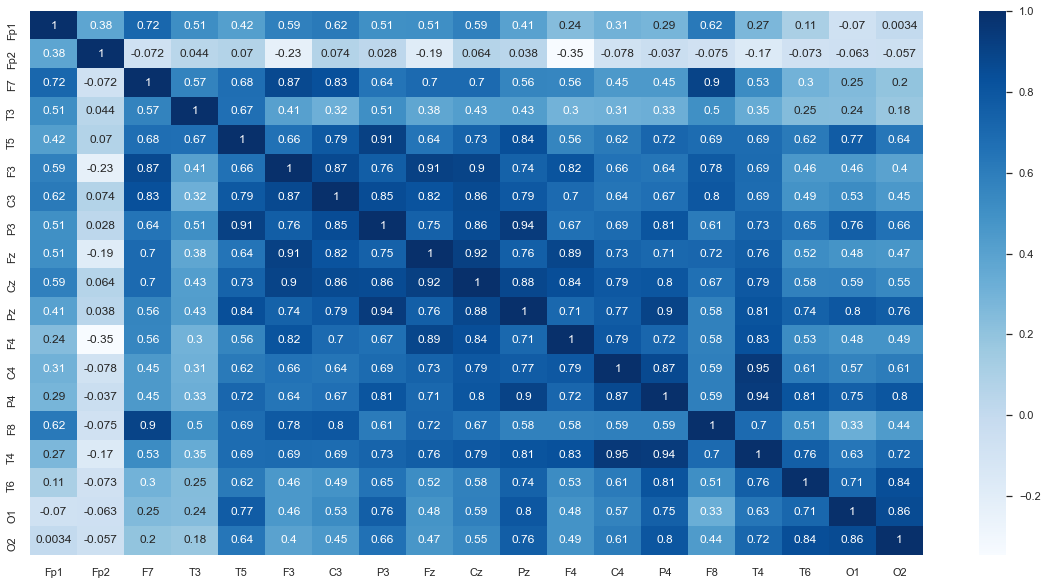

In [25]:
# Heat map to examine colleration between the channels
heat = df_range.corr()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(heat, annot=True, cmap=plt.cm.Blues);

### The Elbow Method

ADD MORE DESCRIPTION

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**
- The inertia decreases as K increases
- The intra-cluster distance in our toy example above is given as   

$$ \sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance

In [22]:
kmeans.inertia_

59992715.03889909

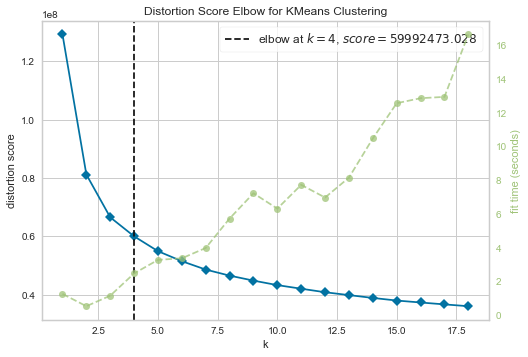

In [17]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 19)) #Range of K values
visualizer.fit(X)  # Fit the data
visualizer.show();

### The Silhouette method

- Not dependent on the notion of cluster centers 
- Calculated using the **mean intra-cluster distance** ($a$) and the **mean nearest-cluster distance** ($b$) for each sample
- the difference between the **the average nearest-cluster distance** ($b$) and **average intra-cluster distance** ($a$) for each sample, normalized by the maximum value

$$\frac{b-a}{max(a,b)}$$

- The best value is 1
- The worst value is -1 (samples have been assigned to wrong clusters)
- Value near 0 means overlapping clusters

The overall **Silhouette score** is the average of the Silhouette scores for all samples.

##### Interpretation

-	The plots show the Silhouette scores for each sample in that cluster
-	Higher scores indicate well separated clusters
-	The size represents the size of samples in each cluster
-	The thickness of each silhouette indicates the cluster size
-	The shape of each silhouette indicates the "goodness" for points in each cluster


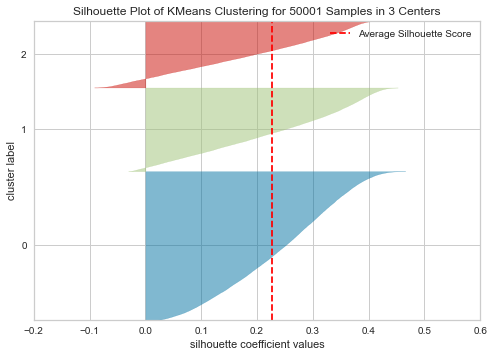

In [18]:
# Single K value KMeans(n_clusters, random_state=42)
model2 = KMeans(3)
visualizer = SilhouetteVisualizer(model2, colors="yellowbrick")
visualizer.fit(X)  # Fit the data 
visualizer.show();

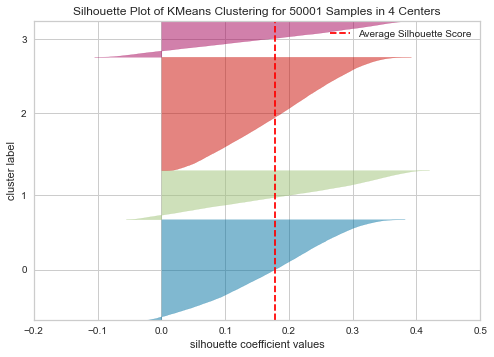

In [19]:
model3 = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model3, colors="yellowbrick")
visualizer.fit(X)  # Fit the data 
visualizer.show();

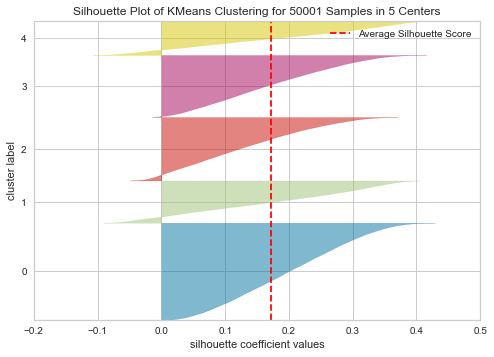

In [21]:
model4 = KMeans(5, random_state=123)
visualizer = SilhouetteVisualizer(model4, colors="yellowbrick")
visualizer.fit(X)  # Fit the data 
visualizer.show();

#### Principal Component Analysis (PCA)

In unsupervised learning techniques such as clustering are based on the notion of distances between points. With increased dimensions, the representation of data becomes more complex.

Dimensionality reduction is the task of reducing a dataset in high dimension (our df is 50,001) to low dimension while retaining the most "important" characteristics of the data.

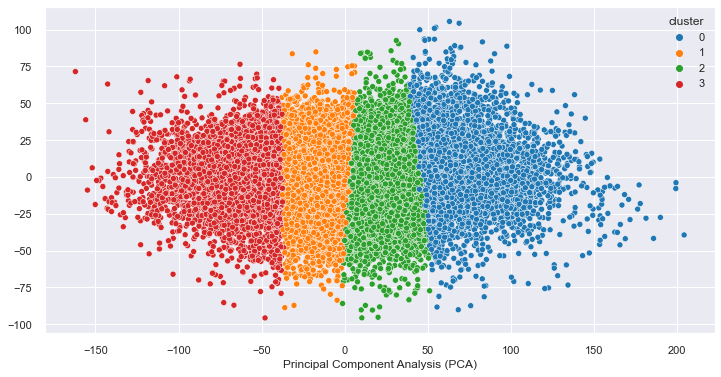

In [51]:
# Plot Function

def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["Principal Component Analysis (PCA)", ""], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(12, 6))
    ax = sns.scatterplot(
        x="Principal Component Analysis (PCA)", y="", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()
plot_pca_clusters(df_range, kmeans.labels_)

### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- DBSCAN is a density-based clustering algorithm
- ntuitively, it's based on the idea that clusters form dense regions in the data and so it works by identifying "crowded" regions in the feature space

In [26]:
# Plot function

def plot_X_dbscan(X, model):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    colours = []
    if np.any(model.labels_ == -1):
        n_clusters = len(set(model.labels_)) - 1 
    else: 
        n_clusters = len(set(model.labels_))
    
    for i in range(n_clusters + 1):
        colours.append("#%06X" % np.random.randint(0, 0xFFFFFF))
        
    mglearn.discrete_scatter(X[:, 0], X[:, 1], ax=axes[0], markeredgewidth=1.0)

    if np.any(model.labels_ == -1):
        colours = ["w"] + colours
    mglearn.discrete_scatter(X[:, 0], X[:, 1], model.labels_, c=colours, markers="o", markeredgewidth=1.0, ax=axes[1]);
    plt.legend()

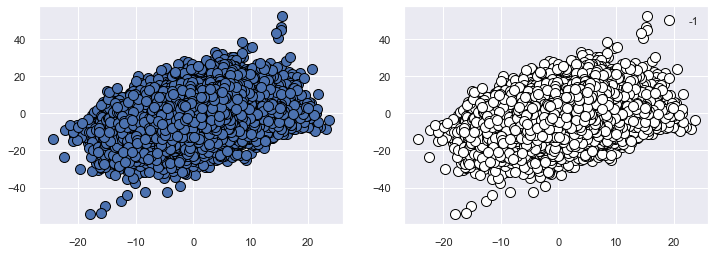

In [71]:
# eps: determines what it means for points to be "close"
# min_samples: determines the number of neighboring points we require to consider in order for a point to be part of a cluster

dbscan = DBSCAN(eps=3, min_samples=50)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

- Increasing `eps` ($\uparrow$) (left to right in the plot above) means more points will be included in a cluster.  
- Increasing `min_samples` ($\uparrow$) (top to bottom in the plot above) means points in less dense regions will either be labeled as their own cluster or noise. 
- In general, it's not trivial to tune these hyperparameters. 


In [72]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:{}".format(clusters))

Cluster memberships:[-1 -1 -1 ... -1 -1 -1]


- noise points: shown in white
- core points: bigger
- border points: smaller

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


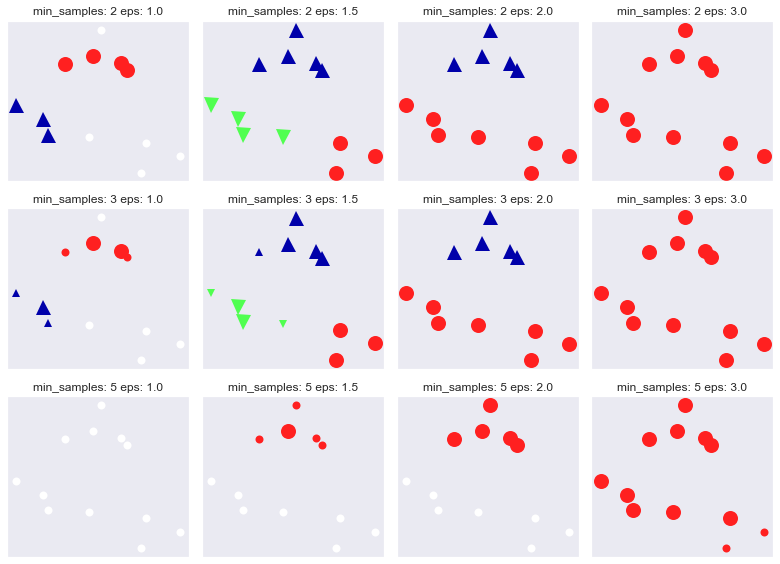

In [73]:
mglearn.plots.plot_dbscan()

### Statistical analysis for each clustering group

In [ ]:
df_c0 = raw_predict[raw_predict['Cluster'] == 0]
df_c1 = raw_predict[raw_predict['Cluster'] == 1]
df_c2 = raw_predict[raw_predict['Cluster'] == 2]
df_c3 = raw_predict[raw_predict['Cluster'] == 3]

print(df_c0, df_c1, df_c2, df_c3)

In [31]:
raw_predict.describe()

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
count,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,-0.327692,-0.522908,0.127767,-0.311422,0.476719,0.505070,0.381643,0.365647,0.649448,0.553179,0.597412,0.928698,0.939105,0.995151,0.366328,0.745060,1.017673,1.068502,1.120582,1.199176
std,5.196304,7.927778,10.736381,20.576980,11.737982,11.006524,12.534893,11.772534,10.122267,11.729350,11.578568,11.885575,13.540232,11.715911,8.607544,8.252425,11.507485,11.569579,12.512598,1.075727
min,-24.413050,-54.143478,-45.680988,-116.256851,-43.839943,-50.281010,-52.267605,-45.626858,-39.255898,-50.632957,-44.775906,-68.354919,-124.311409,-71.519905,-37.635292,-63.708252,-66.545052,-51.405544,-86.921539,0.000000
25%,-3.728066,-5.565413,-6.970666,-12.368559,-7.077387,-6.813342,-7.781343,-7.424434,-5.902663,-7.160944,-6.940023,-6.670228,-7.492259,-6.640830,-5.056301,-4.458212,-6.189438,-6.416380,-6.879982,0.000000
50%,-0.389864,-0.379719,-0.529755,0.060875,0.217127,0.004274,0.154477,0.249235,0.466422,0.460289,0.372989,0.668720,0.810214,0.703931,0.072412,0.545363,0.714966,0.646951,0.909252,1.000000
75%,3.043671,4.605313,6.415783,12.311707,7.588174,7.191943,8.125086,7.882903,7.016030,8.058373,8.124215,8.161564,9.199770,8.490211,5.526936,5.742227,8.099813,7.984443,8.806051,2.000000
max,23.660351,52.204121,57.200550,104.290550,61.924137,55.081165,67.112480,59.108391,48.581398,51.524139,64.061562,84.867432,94.694199,59.571434,35.287170,43.708790,70.306602,78.302246,83.649689,3.000000


In [33]:
df_c0.describe()

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
count,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.000000,18935.0
mean,-1.139214,-0.177618,-2.725804,-4.327155,-3.527167,-3.100017,-3.684355,-3.938552,-2.585969,-3.583556,-3.749459,-2.826130,-3.250191,-3.063224,-1.972182,-2.027595,-2.316698,-2.472769,-2.492950,0.0
std,4.258000,7.649001,7.108352,16.580572,5.856155,6.187885,7.022345,5.265207,5.464008,5.302484,4.918510,7.191304,7.698042,5.786449,5.374792,4.064680,7.689113,7.591194,8.536296,0.0
min,-24.413050,-35.116543,-45.346222,-97.260437,-31.569448,-30.541739,-31.919874,-24.131718,-23.134789,-24.402132,-23.933949,-48.229218,-49.914558,-27.761871,-27.986128,-22.927177,-51.972450,-36.718868,-66.056084,0.0
25%,-3.972341,-5.180691,-7.439084,-13.294135,-7.466111,-7.223105,-8.360877,-7.477859,-6.241375,-7.229169,-7.027231,-7.265290,-8.113347,-6.979811,-5.573419,-4.700095,-7.083014,-7.398008,-7.878206,0.0
50%,-1.254189,-0.216491,-2.883563,-3.303226,-3.567002,-3.215790,-3.961735,-3.851603,-2.619065,-3.549243,-3.603475,-2.736014,-3.304975,-2.949980,-1.970679,-2.020483,-2.123050,-2.318635,-2.324899,0.0
75%,1.636230,4.675379,1.784329,5.996394,0.381227,0.846348,0.676278,-0.299303,1.018128,0.061056,-0.319777,1.799064,1.538100,0.873041,1.615779,0.635277,2.628267,2.550731,3.132171,0.0
max,16.800903,35.031090,30.144276,68.103889,21.260170,25.693598,31.941847,15.447214,17.615112,17.104593,14.615954,47.788857,66.710770,43.998539,24.900076,36.812916,50.919582,35.385044,39.777275,0.0


In [34]:
df_c1.describe()

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
count,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.000000,8179.0
mean,-4.577693,-0.660005,-11.049938,-17.229519,-14.803154,-13.143947,-15.599135,-15.929773,-12.531262,-15.832845,-15.551742,-13.203634,-16.058787,-14.577170,-9.388820,-10.112807,-11.257727,-10.890291,-11.896397,1.0
std,4.595607,7.621720,7.717911,18.111164,7.424752,6.710423,8.439052,6.308536,6.556428,6.501103,6.221943,8.097154,9.966394,7.261726,6.806859,5.440930,9.063909,8.682508,10.002788,0.0
min,-21.402178,-31.882256,-45.680988,-116.256851,-43.839943,-50.281010,-52.267605,-45.626858,-39.255898,-50.632957,-44.775906,-68.354919,-124.311409,-71.519905,-37.635292,-63.708252,-66.545052,-51.405544,-86.921539,1.0
25%,-7.489974,-5.885059,-15.671108,-27.728552,-19.286264,-17.293676,-20.469907,-19.772496,-16.505292,-19.893635,-19.371327,-18.170144,-21.657686,-18.891755,-13.590084,-13.080759,-16.421495,-16.110827,-17.671498,1.0
50%,-4.452204,-1.005584,-10.665172,-15.578339,-14.036600,-12.858312,-15.196276,-15.346721,-12.149760,-15.322582,-15.143105,-12.663800,-14.911880,-13.851864,-8.726789,-9.345905,-10.549439,-10.544246,-11.228917,1.0
75%,-1.649365,4.044765,-5.930109,-5.488306,-9.746246,-8.723227,-10.357798,-11.517544,-8.097898,-11.287793,-11.169400,-7.790061,-9.594394,-9.542255,-4.712449,-6.466421,-5.125801,-5.070524,-5.410928,1.0
max,13.539838,28.968082,19.875763,54.027493,9.192141,11.127036,22.787941,5.061398,11.522840,4.456090,6.133224,26.288683,34.039841,7.895671,11.215179,12.014411,20.116407,16.330666,19.977928,1.0


In [35]:
df_c2.describe()

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
count,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.0
mean,1.122481,-0.108358,3.364181,4.334243,5.819291,5.110338,6.105810,6.535128,5.339897,6.616508,6.836081,5.943878,7.357669,6.991228,3.375879,4.707608,5.714657,5.830435,6.478088,2.0
std,4.502900,7.761438,7.754400,17.138668,5.948700,6.426993,7.150687,5.483373,5.767780,5.565366,5.193686,7.493548,8.156518,6.351088,5.723133,4.379607,8.255976,8.227642,9.178990,0.0
min,-22.436729,-50.081032,-36.656994,-106.190872,-16.532291,-22.986544,-24.650032,-12.892207,-15.979677,-12.968257,-10.932568,-31.932957,-31.082569,-14.560960,-22.481661,-12.138189,-41.221073,-27.947838,-34.088337,2.0
25%,-1.789762,-4.894160,-1.792061,-5.265659,1.843498,0.731720,1.380488,2.854178,1.418674,2.816870,3.247919,1.273167,2.233913,2.650312,-0.549260,1.790763,0.321104,0.304020,0.548963,2.0
50%,1.188769,0.216721,3.276529,5.078369,5.730771,4.967342,5.729250,6.339580,5.189643,6.488879,6.742831,5.734537,7.019696,6.969950,3.260268,4.567500,5.736002,5.648131,6.436661,2.0
75%,4.103335,5.043592,8.491208,15.278472,9.727253,9.234150,10.330315,10.143547,9.087363,10.252193,10.250700,10.528292,12.084987,11.210041,7.197976,7.400697,10.942004,11.311201,12.372827,2.0
max,19.224974,44.656704,39.933113,84.749367,36.285469,35.135353,44.452820,31.559744,27.290020,27.283516,27.888145,58.616226,82.334282,55.102432,28.822399,42.699520,67.900894,53.693203,83.649689,2.0


In [36]:
df_c3.describe()

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
count,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.0
mean,3.941998,-2.589556,15.247488,22.327530,18.889414,17.512011,18.872155,18.784059,15.614134,18.865373,18.756762,17.913844,19.251858,18.141405,12.563068,13.133758,15.043265,15.132678,15.179749,3.0
std,5.574355,9.231951,9.814998,19.292928,8.752246,8.176092,8.830028,7.836288,7.171928,7.333991,7.573935,9.500815,10.828541,8.645512,7.036438,6.183413,10.658298,11.996980,12.263276,0.0
min,-17.990000,-54.143478,-20.268135,-61.377399,-7.051767,-15.150782,-9.279719,-2.023971,-6.692920,-5.411249,-4.256673,-12.965459,-17.364862,-9.757254,-9.856727,-7.372205,-30.038519,-19.101267,-33.074356,3.0
25%,0.457288,-8.486541,8.189674,11.129550,12.720115,11.762954,12.639175,13.382175,10.881984,13.848606,13.607518,11.917627,12.409428,12.608956,7.787962,8.941185,8.123645,7.059784,7.412103,3.0
50%,3.981410,-2.010588,14.836543,21.561939,17.770775,16.823702,18.041996,17.699451,15.011485,18.216984,17.712088,17.368500,18.278027,17.649370,12.409566,12.581920,14.991098,14.574270,15.048529,3.0
75%,7.212427,3.669409,21.863290,33.533037,23.712117,22.613948,24.291841,23.185154,20.039882,23.233471,22.688020,23.364726,24.754205,23.115275,17.354231,16.702547,21.625763,22.500002,23.059604,3.0
max,23.660351,52.204121,57.200550,104.290550,61.924137,55.081165,67.112480,59.108391,48.581398,51.524139,64.061562,84.867432,94.694199,59.571434,35.287170,43.708790,70.306602,78.302246,78.589500,3.0


#### Visualizing clustering groups

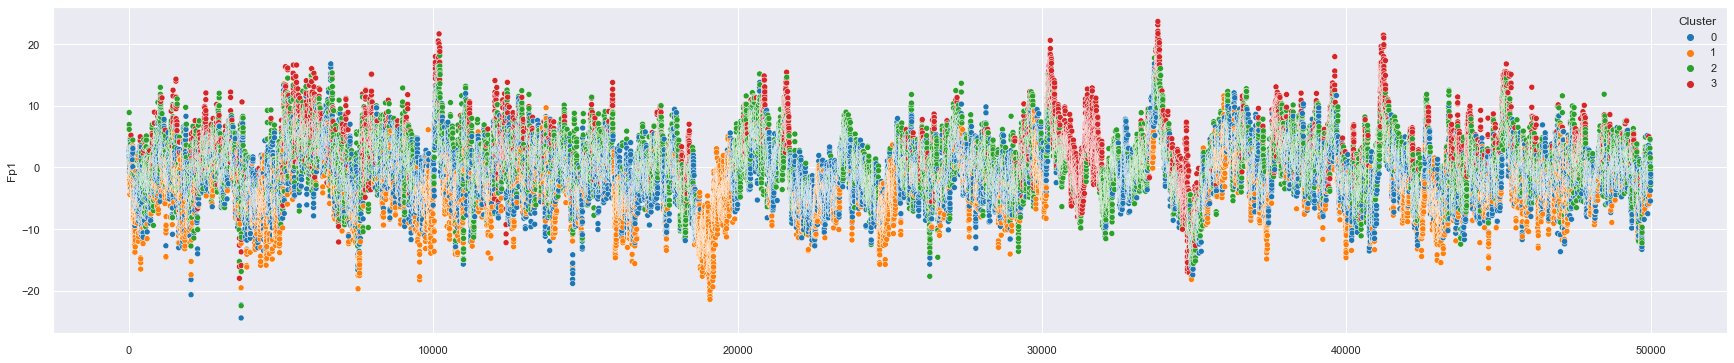

In [38]:
plt.figure(figsize=(30, 6))
ax = sns.scatterplot(
    x=raw_predict.index, y="Fp1", hue="Cluster", data=raw_predict, palette="tab10"
)
plt.show()

In [27]:
dff = raw_predict.reset_index().melt(id_vars=["Cluster", "index"])
dff.tail()

,Cluster,index,variable,value
950014,1,49996,O2,1.902911
950015,1,49997,O2,1.702189
950016,3,49998,O2,0.527909
950017,3,49999,O2,3.492633
950018,3,50000,O2,-0.808997


<Figure size 2880x1440 with 0 Axes>

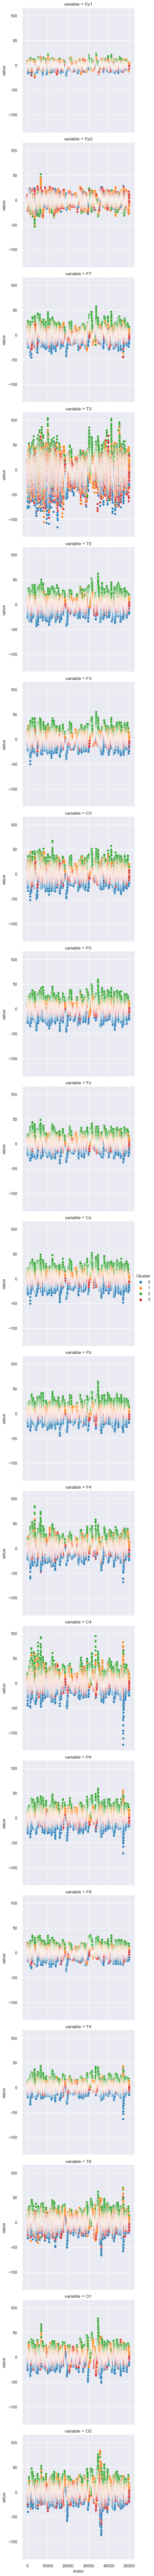

In [28]:
plt.figure(figsize=(60, 40))
ax = sns.relplot(
    x="index", y="value", hue="Cluster", row="variable", data=dff, palette="tab10"
)
plt.show()